# 實作一般化的人工神經網路模型

## 資料集：一個螺旋狀的二維資料集

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(99)  # 固定隨機種子，讓每次產生的亂數結果都一樣，方便重現結果

def gen_spiral_dataset(N=100, D=2, K=3):
    X = np.zeros((N*K, D))  # 建立資料矩陣，每一列代表一筆資料
    y = np.zeros(N*K, dtype='uint8')  # 建立標籤陣列，用來存每筆資料的類別

    for j in range(K):  # 依序產生每一個類別的資料
        ix = range(N*j, N*(j+1))  # 計算目前類別在資料中的索引範圍
        r = np.linspace(0.0, 1, N)  # 半徑，從中心往外均勻增加
        t = np.linspace(j*4, (j+1)*4, N) + np.random.randn(N)*0.2  # 角度，加上一點雜訊讓資料比較分散
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]  # 轉成平面座標，形成螺旋狀
        y[ix] = j  # 設定對應的類別標籤

    return X, y  # 回傳資料與標籤

# N, D, K = 100, 2, 3  # 設定每個類別的資料數量、維度、類別數

# X_spiral, y_spiral = gen_spiral_dataset()  # 產生螺旋狀資料集

# plt.scatter(
#     X_spiral[:, 0],
#     X_spiral[:, 1],
#     c=y_spiral,        # 依照類別上色
#     s=40,              # 點的大小
#     cmap=plt.cm.Spectral  # 使用光譜色盤
# )
# plt.show()  # 顯示圖表

## 啟動、損失函數與其梯度（導數）

In [2]:
import numpy as np

def sigmoid(x):
    # Sigmoid 函數，常用在二元分類，將輸入值壓到 0~1 之間
    return 1 / (1 + np.exp(-x))

def binary_cross_entropy(f, y, epsilon=1e-8):
    # 二元交叉熵損失函數
    # f: 模型預測值 (機率)
    # y: 真實標籤 (0 或 1)
    # epsilon: 避免 log(0) 用的小常數

    # 原本可能是想逐筆算 loss（被註解掉）
    # np.sum(y*np.log(f+epsilon)+ (1-y)*np.log(1-f+epsilon), axis=1)

    m = len(y)  # 資料筆數
    # 計算整體平均 loss
    return - (1./m) * np.sum(
        np.multiply(y, np.log(f + epsilon)) +
        np.multiply((1 - y), np.log(1 - f + epsilon))
    )

def binary_cross_entropy_grad(out, y, sigmoid_out=True, epsilon=1e-8):
    # 計算 binary cross entropy 對輸出值的梯度
    # out: 模型輸出
    # y: 真實標籤
    # sigmoid_out: 表示 out 是否已經過 sigmoid

    if sigmoid_out:
        f = out  # 如果已經是 sigmoid 輸出，直接使用
        grad = ((f - y) / (f * (1 - f) + epsilon)) / (len(y))
    else:
        f = sigmoid(out)  # 如果 out 是 z，先做 sigmoid
        grad = (f - y) / (len(y))

def binary_cross_entropy_loss_grad(out, y, sigmoid_out=True, epsilon=1e-8):
    # 同時計算 loss 與 gradient
    # 常用在訓練時一次回傳兩個結果

    if sigmoid_out:
        f = out  # 已經是 sigmoid 結果
        grad = ((f - y) / (f * (1 - f) + epsilon)) / (len(y))
    else:
        f = sigmoid(out)  # out 是尚未經過 sigmoid 的值
        grad = (f - y) / (len(y))

    # 計算 binary cross entropy loss
    loss = binary_cross_entropy(f, y, epsilon)

    return loss, grad

def mse_loss_grad(f, y):
    m = len(f)
    # 計算資料筆數（樣本數）

    loss = (1./m) * np.sum((f - y) ** 2)
    # 計算 MSE（均方誤差），用來衡量預測值跟實際值的差距

    grad = (2./m) * (f - y)
    # 計算 MSE 對預測值 f 的梯度，常用在梯度下降

    return loss, grad
    # 回傳 loss 值以及對應的梯度

def softmax(Z):
    # 對輸入的 Z 做 softmax，先減掉最大值避免數值爆掉
    A = np.exp(Z - np.max(Z, axis=-1, keepdims=True))
    # 將指數結果做正規化，讓每一列加起來等於 1
    return A / np.sum(A, axis=-1, keepdims=True)

def softmax_cross_entropy(Z, y, onehot=False):
    # 樣本的總數（有幾筆資料）
    m = len(Z)

    # 先把模型輸出 Z 丟進 softmax，算出每一類的機率
    F = softmax(Z)

    if onehot:
        # 如果 y 是 one-hot 編碼
        # 直接用 cross entropy 的公式算 loss
        loss = -np.sum(y * np.log(F)) / m
    else:
        # 如果 y 是類別的 index（例如 0、1、2）
        # 把 y 攤平成一維（但這行實際上不會影響後面）
        y.flatten()

        # 取出每筆資料「正確類別」對應的機率，再取 log
        log_Fy = -np.log(F[range(m), y])

        # 把所有樣本的 loss 加起來，再取平均
        loss = np.sum(log_Fy) / m

    return loss

def cross_entropy_grad(Z, Y, onehot=False, softmax_out=False):
    # 判斷輸入的 Z 是不是已經是 softmax 的輸出
    if softmax_out:
        F = Z
    else:
        # 如果不是，就先做一次 softmax
        F = softmax(Z)

    if onehot:
        # 如果 Y 是 one-hot 編碼，直接用 F - Y
        dZ = (F - Y) / len(Z)
    else:
        # 如果 Y 是類別索引（例如 [0, 2, 1]）
        m = len(Y)          # 樣本數
        dZ = F.copy()       # 複製一份避免動到原本的 F
        # 對正確類別的位置減 1
        dZ[np.arange(m), Y] -= 1
        # 對 batch size 做平均
        dZ /= m

        # 以下是另一種寫法，這裡先註解起來
        # I_i = np.zeros_like(Z)
        # I_i[np.arange(len(Z)),Y] = 1
        # return (F - I_i) /len(Z)  #Z.shape[0]

    # 回傳對 Z 的梯度
    return dZ

def dRelu(x):
    # ReLU 的微分：x > 0 回傳 1，否則回傳 0
    return 1 * (x > 0)

def max_abs(s):
    # 計算一組矩陣或向量中，所有元素的最大絕對值
    max_value = 0
    for x in s:
        max_value_ = np.max(np.abs(x))  # 取單一矩陣的最大絕對值
        if(max_value_ > max_value):
            max_value = max_value_
    return max_value

# 人工神經網路簡單實作

僅有一個輸入層、一個隱藏層與一個輸出層的人工神經網路，可以設定各層的神經元數量。

In [3]:
class TwoLayerNN:
    def __init__(self, input_units, hidden_units, output_units):
        # 初始化網路結構大小
        n = input_units      # 輸入層神經元數量
        h = hidden_units     # 隱藏層神經元數量
        K = output_units     # 輸出層神經元數量

        # 權重初始化（使用小的隨機值）
        self.W1 = 0.01 * np.random.randn(n, h)
        self.b1 = np.zeros((1, h))
        self.W2 = 0.01 * np.random.randn(h, K)
        self.b2 = np.zeros((1, K))

    def train(self, X, y, reg=0, iterations=10000, learning_rate=1e-0, epsilon=1e-8):
        # 訓練模型
        m = X.shape[0]   # 資料筆數

        # 取出目前參數
        W1 = self.W1
        b1 = self.b1
        W2 = self.W2
        b2 = self.b2

        for i in range(iterations):
            # ===== Forward pass（前向傳播）=====
            Z1 = np.dot(X, W1) + b1       # 第一層線性運算
            A1 = np.maximum(0, Z1)        # ReLU 啟用函數
            Z2 = np.dot(A1, W2) + b2      # 輸出層線性運算

            # 計算 loss，包括正則化的項目
            data_loss = softmax_cross_entropy(Z2, y)  # 資料誤差
            reg_loss = reg * np.sum(W1 * W1) + reg * np.sum(W2 * W2)  # 正則化項
            loss = data_loss + reg_loss

            # 每 1000 次印出目前 loss
            if i % 1000 == 0:
                print("iteration %d: loss %f" % (i, loss))

            # ===== Backward pass（反向傳播）=====
            dZ2 = cross_entropy_grad(Z2, y)   # 輸出層梯度
            dW2 = np.dot(A1.T, dZ2) + 2 * reg * W2  # W2 梯度
            db2 = np.sum(dZ2, axis=0, keepdims=True)  # b2 梯度
            dA1 = np.dot(dZ2, W2.T)           # 回傳到隱藏層

            # ReLU 反向傳播（小於等於 0 的位置梯度設為 0）
            dA1[A1 <= 0] = 0
            dZ1 = dA1

            # 以下是其他寫法（目前未使用）
            # dZ1 = dA1 * dReLU(A1)
            dZ1 = np.multiply(dA1, dRelu(A1))

            dW1 = np.dot(X.T, dZ1) + 2 * reg * W1  # W1 梯度
            db1 = np.sum(dZ1, axis=0, keepdims=True)  # b1 梯度

            # 如果梯度都小於 epsilon，提早停止訓練
            if max_abs([dW2, db2, dW1, db1]) < epsilon:
                print("gradient is small enough at iter : ", i)
                break

            # ===== 更新參數（Gradient Descent）=====
            W1 += -learning_rate * dW1
            b1 += -learning_rate * db1
            W2 += -learning_rate * dW2
            b2 += -learning_rate * db2

        return W1, b1, W2, b2

    def predict(self, X):
        # 使用目前模型做預測（前向傳播）
        Z1 = np.dot(X, W1) + b1
        A1 = np.maximum(0, Z1)  # ReLU
        Z2 = np.dot(A1, W2) + b2
        return Z2


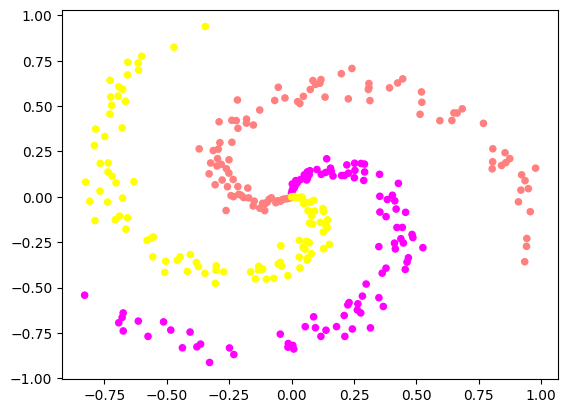

In [4]:
# 設定隨機種子，確保每次執行產生的隨機結果都一樣，方便重現實驗結果
np.random.seed(89)

# 產生螺旋狀的資料集
# X 代表特徵資料，y 代表對應的標籤
X, y = gen_spiral_dataset()

# 將資料視覺化成散佈圖
# X[:, 0]：取第一個特徵當作 x 軸
# X[:, 1]：取第二個特徵當作 y 軸
# c=y：依照標籤 y 來上色
# s=20：設定每個點的大小
# cmap=plt.cm.spring：使用 spring 的顏色對應表
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap=plt.cm.spring)

# 顯示圖表
plt.show()


In [5]:
# 建立一個兩層的類神經網路
# 輸入層有 2 個特徵、隱藏層有 100 個神經元、輸出層有 3 個分類
input_layer_size = 2
hidden_layer_size = 100
output_layer_size = 3
ann = TwoLayerNN(input_layer_size, hidden_layer_size, output_layer_size)

# 使用訓練資料 X 跟標籤 y 來訓練模型
# 訓練完成後，回傳第一層與第二層的權重與偏置
W1, b1, W2, b2 = ann.train(X, y)


iteration 0: loss 1.098627
iteration 1000: loss 0.115216
iteration 2000: loss 0.053218
iteration 3000: loss 0.038299
iteration 4000: loss 0.031767
iteration 5000: loss 0.028016
iteration 6000: loss 0.025411
iteration 7000: loss 0.023476
iteration 8000: loss 0.022009
iteration 9000: loss 0.020872


training accuracy: 0.99


(-1.9124776305480737, 1.9275223694519297)

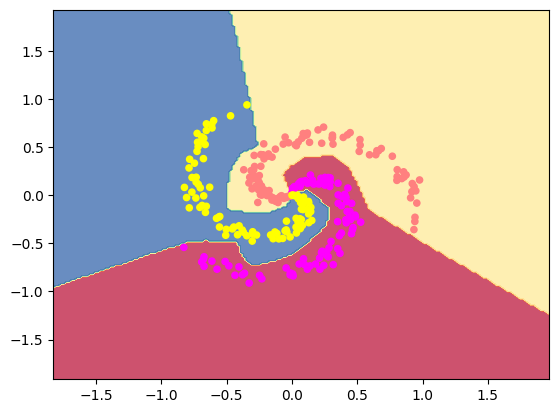

In [6]:
# ===== 計算訓練資料的準確率 =====

# 原本手動做 forward pass（目前已註解掉，改用 nn.predict）
# A1 = np.maximum(0, np.dot(X, W1) + b1)  # 第一層，ReLU 啟用函數
# Z2 = np.dot(A1, W2) + b2                # 第二層輸出

Z2 = ann.predict(X)                        # 使用模型預測訓練資料的輸出結果
predicted_class = np.argmax(Z2, axis=1)   # 取每筆資料機率最大的類別
print ('training accuracy: %.2f' % (np.mean(predicted_class == y)))
                                          # 計算並印出訓練集的分類正確率

# ===== 繪製分類結果（決策邊界） =====

h = 0.02                                  # 網格的解析度，數值越小圖越細
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1  # x 軸範圍
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1  # y 軸範圍

# 產生整個平面上的網格點
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

XX = np.c_[xx.ravel(), yy.ravel()]         # 將網格點整理成模型可輸入的格式
Z = ann.predict(XX)                         # 對整個平面做預測
Z = np.argmax(Z, axis=1)                   # 取預測類別
Z = Z.reshape(xx.shape)                    # 轉回網格形狀以利畫圖

fig = plt.figure()                         # 建立圖表
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
                                          # 畫出分類區域（決策邊界）
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap=plt.cm.spring)
                                          # 疊加原始資料點
plt.xlim(xx.min(), xx.max())               # 設定 x 軸顯示範圍
plt.ylim(yy.min(), yy.max())               # 設定 y 軸顯示範圍


# 人工神經網路的簡單通用框架

使用物件導向，開發一個通用且可拓展的人工神經網路框架。

In [7]:
# 神經網路層類別
class Layer:
    def __init__(self):
        pass

    def forward(self, x):
        # 前向傳播，實際運算由子類別實作
        raise NotImplementedError

    def backward(self, grad):
        # 反向傳播，實際梯度計算由子類別實作
        raise NotImplementedError


class Dense(Layer):
    def __init__(self, input_dim, out_dim, activation=None):
        super().__init__()
        # 初始化權重矩陣，數值縮小避免一開始數值太大
        self.W = np.random.randn(input_dim, out_dim) * 0.01
        # 初始化 bias，全部設為 0
        self.b = np.zeros((1, out_dim))

        # 紀錄使用的啟動函數類型
        self.activation = activation
        # 儲存前向傳播後的輸出
        self.A = None

    def forward(self, x):
        # 前向傳播：計算線性組合 f(x) = xW + b
        self.x = x  # 保留輸入，供反向傳播使用
        Z = np.matmul(x, self.W) + self.b
        # 套用啟動函數
        self.A = self.g(Z)
        return self.A

    def backward(self, dA_out):
        # 反向傳播：計算梯度
        A_in = self.x  # 前一層的輸入
        # 計算 dZ
        dZ = self.dZ_(dA_out)

        # 計算權重與 bias 的梯度
        self.dW = np.dot(A_in.T, dZ)
        self.db = np.sum(dZ, axis=0, keepdims=True)
        # 計算傳回前一層的梯度
        dA_in = np.dot(dZ, np.transpose(self.W))
        return dA_in

    def g(self, z):
        # 啟動函數
        if self.activation == 'relu':
            # ReLU
            return np.maximum(0, z)
        elif self.activation == 'sogmiod':
            # Sigmoid
            return 1 / (1 + np.exp(-z))
        else:
            # 沒有指定啟動函數就直接輸出
            return z

    def dZ_(self, dA_out):
        # 計算啟動函數對 Z 的微分
        if self.activation == 'relu':
            # ReLU 的梯度
            grad_g_z = 1. * (self.A > 0)
            return np.multiply(dA_out, grad_g_z)
        elif self.activation == 'sogmiod':
            # Sigmoid 的梯度
            grad_g_z = self.A(1 - self.A)
            return np.multiply(dA_out, grad_g_z)
        else:
            # 無啟動函數時，梯度直接往前傳
            return dA_out

## 測試：人工神經網路的向前函式

In [8]:
import numpy as np

# 設定隨機種子，確保每次產生的隨機數結果都一樣，方便除錯與重現結果
np.random.seed(1)

# 產生一個隨機矩陣
# 形狀為 (3, 48)，代表 3 筆資料，每筆資料有 48 個特徵
x = np.random.randn(3, 48)  # 3 個樣本，每個樣本有 48 維特徵

# 建立一個全連接層 (Dense Layer)
# 輸入維度為 48，輸出維度為 10，啟用函數設定為 'none'
dense = Dense(48, 10, 'none')

# 將輸入資料丟進 Dense 層做前向傳播
o = dense.forward(x)

# 輸出結果的形狀
print(o.shape)

# 輸出實際計算結果
print(o)

(3, 10)
[[-0.03953509 -0.00214997  0.00743433 -0.16926214 -0.05162853  0.06734225
  -0.00221485 -0.11710758 -0.07046456  0.02609659]
 [ 0.00848392  0.08259757 -0.09858177  0.0374092  -0.08303008  0.04151241
  -0.01407859 -0.02415486  0.04236149  0.0648261 ]
 [-0.13877363 -0.04122276 -0.00984716 -0.03461381  0.11513754  0.1043094
   0.00170353 -0.00449278 -0.0057236  -0.01403174]]


In [9]:
def numerical_gradient_from_df(f, p, df, h=1e-5):
  # 建立一個與 p 形狀相同、內容全為 0 的陣列，用來存每個參數的梯度
  grad = np.zeros_like(p)

  # 使用 nditer 逐一走訪 p 中的每一個元素（支援多維陣列）
  it = np.nditer(p, flags=['multi_index'], op_flags=['readwrite'])

  # 只要 iterator 還沒跑完就持續計算
  while not it.finished:
    # 取得目前走訪到的索引位置
    idx = it.multi_index

    # 先把原本的參數值存起來
    oldval = p[idx]

    # 將該參數往正方向微調一點
    p[idx] = oldval + h
    pos = f()       # 在參數被改動後重新呼叫 f()，取得正方向的輸出結果

    # 將該參數往負方向微調一點
    p[idx] = oldval - h
    neg = f()       # 在參數被改動後重新呼叫 f()，取得負方向的輸出結果

    # 將參數值還原成原本的狀態，避免影響下一次計算
    p[idx] = oldval

    # 使用中央差分法計算梯度，並與上游傳下來的 df 做加權
    grad[idx] = np.sum((pos - neg) * df) / (2 * h)

    # 另一種寫法（使用內積），目前被註解掉
    # grad[idx] = np.dot((pos - neg), df) / (2 * h)

    # 移動到下一個參數位置
    it.iternext()

  # 回傳整個參數 p 的數值梯度
  return grad

In [15]:
df = np.random.randn(3, 10)
dx = dense.backward(df)
dx_num = numerical_gradient_from_df(lambda :dense.forward(x),x,df)

diff_error = lambda x, y: np.max(np.abs(x - y))
print(diff_error(dx,dx_num))

dW_num = numerical_gradient_from_df(lambda :dense.forward(x),dense.W,df)
print(diff_error(dense.dW,dW_num))

2.876775206939186e-12
1.846564567919984e-12


In [11]:
class NeuralNetwork:
    def __init__(self):
        self._layers = []   # 用來存放所有網路層的清單

    def add_layer(self, layer):
        self._layers.append(layer)  # 將新的 layer 加到網路中

    def forward(self, X):
        self.X = X              # 記錄輸入資料
        for layer in self._layers:
            X = layer.forward(X)  # 依序經過每一層做 forward 計算
        return X                 # 回傳最後輸出

    def predict(self, X):
        p = self.forward(X)     # 先做 forward 得到預測結果

        if p.ndim == 1:         # 如果是單一樣本
            return np.argmax(p)  # 回傳機率最大的類別

        # 多筆樣本的情況
        return np.argmax(p, axis=1)


    def backward(self, loss_grad, reg=0.):
        # 反向傳播，從最後一層往前算梯度
        for i in reversed(range(len(self._layers))):
            layer = self._layers[i]
            loss_grad = layer.backward(loss_grad)

        # 將正則化項加入權重梯度
        for i in range(len(self._layers)):
            self._layers[i].dW += 2 * reg * self._layers[i].W

    def reg_loss(self, reg):
        loss = 0
        # 計算所有層的 L2 正則化損失
        for i in range(len(self._layers)):
            loss += reg * np.sum(self._layers[i].W * self._layers[i].W)
        return loss

    def update_parameters(self, learning_rate):
        # 依照學習率更新每一層的權重與偏置
        for i in range(len(self._layers)):
            self._layers[i].W += -learning_rate * self._layers[i].dW
            self._layers[i].b += -learning_rate * self._layers[i].db

    def parameters(self):
        params = []
        # 收集所有層的參數（權重與偏置）
        for i in range(len(self._layers)):
            params.append(self._layers[i].W)
            params.append(self._layers[i].b)
        return params

    def grads(self):
        grads = []
        # 收集所有層的梯度
        for i in range(len(self._layers)):
            grads.append(self._layers[i].dW)
            grads.append(self._layers[i].db)
        return grads

In [12]:
# 建立一個神經網路物件
nn = NeuralNetwork()

# 新增第一層全連接層：輸入 2 維，輸出 100 維，使用 ReLU 當啟動函數
nn.add_layer(Dense(2, 100, 'relu'))

# 新增第二層全連接層：輸入 100 維，輸出 3 維，使用 softmax 做分類
nn.add_layer(Dense(100, 3, 'softmax'))

# 隨機產生一組輸入資料（2 筆資料，每筆 2 維）
X_temp = np.random.randn(2,2)

# 隨機產生對應的標籤（類別數為 3）
y_temp = np.random.randint(3, size=2)

# 將資料丟進神經網路做前向傳播
F = nn.forward(X_temp)

# 計算 softmax cross entropy 的 loss
loss = softmax_cross_entropy(F,y_temp)

# 計算 cross entropy 對輸出的梯度
loss_grad =  cross_entropy_grad(F,y_temp)

# 印出 loss 以及梯度的平均值，方便快速檢查結果
print(loss, np.mean(loss_grad))

1.098695480580774 -9.25185853854297e-18


In [13]:
def train(nn, X, y, loss_function, epochs=10000, learning_rate=1e-0, reg=1e-3, print_n=10):
    losses = []  # 用來記錄每一個 epoch 的 loss
    for epoch in range(epochs):
        # 前向傳播，計算模型輸出
        f = nn.forward(X)

        # 計算 loss 以及對輸出的梯度
        loss, loss_grad = loss_function(f, y)

        # 加上正則化的 loss
        loss += nn.reg_loss(reg)

        # 反向傳播，計算各層參數的梯度
        nn.backward(loss_grad, reg)

        # 根據學習率更新模型參數
        nn.update_parameters(learning_rate)

        # 每隔 print_n 次印出目前的 loss
        if epoch % print_n == 0:
            print("iteration %d: loss %f" % (epoch, loss))

        # 將目前的 loss 存起來
        losses.append(loss)

    # 回傳所有 epoch 的 loss
    return losses


def cross_entropy_loss(F, Y, onehot=False):
    m = len(F)  # 樣本數
    if onehot:
        # Y 是 one-hot 編碼時的 cross entropy
        return -(1./m) * np.sum(np.multiply(Y, np.log(F)))
    else:
        # Y 是類別標籤時，取對應類別的機率來算 log loss
        return -(1./m) * np.sum(np.log(F[range(m), Y]))


def cross_entropy_grad_loss(F, y, softmax_out=False, onehot=False):
    # 根據輸出是否已經過 softmax，選擇對應的 loss 計算方式
    if softmax_out:
        loss = cross_entropy_loss(F, y, onehot)
    else:
        loss = softmax_cross_entropy(F, y, onehot)

    # 計算 cross entropy 對輸出的梯度
    loss_grad = cross_entropy_grad(F, y, onehot, softmax_out)
    return loss, loss_grad


# 固定亂數種子，方便重現結果
np.random.seed(89)

# 產生螺旋狀的訓練資料
X, y = gen_spiral_dataset()

# 設定訓練參數
epochs = 10000
learning_rate = 1e-0
reg = 1e-4
print_n = epochs // 10

# 開始訓練模型
losses = train(nn, X, y, cross_entropy_grad_loss, epochs, learning_rate, reg, print_n)

# 印出訓練資料上的正確率
print(np.mean(nn.predict(X) == y))

# 印出所有 epoch 的 loss
print(losses)


iteration 0: loss 1.098749
iteration 1000: loss 0.199245
iteration 2000: loss 0.129508
iteration 3000: loss 0.116411
iteration 4000: loss 0.110031
iteration 5000: loss 0.105776
iteration 6000: loss 0.103647
iteration 7000: loss 0.102508
iteration 8000: loss 0.101521
iteration 9000: loss 0.100991
0.9933333333333333
[np.float64(1.0987490312303376), np.float64(1.0985119489017192), np.float64(1.0982755334502554), np.float64(1.0980230187356372), np.float64(1.0977532486939654), np.float64(1.0974631144000864), np.float64(1.0971262509257196), np.float64(1.0967363317223946), np.float64(1.0962743047592842), np.float64(1.0957196003464054), np.float64(1.095049738845521), np.float64(1.094245800707834), np.float64(1.0932791991173518), np.float64(1.0921150243307225), np.float64(1.0907095076527416), np.float64(1.089012130103249), np.float64(1.0869701133816612), np.float64(1.084518604705914), np.float64(1.0815738662379397), np.float64(1.0780474719285114), np.float64(1.0738386748132458), np.float64(1.06

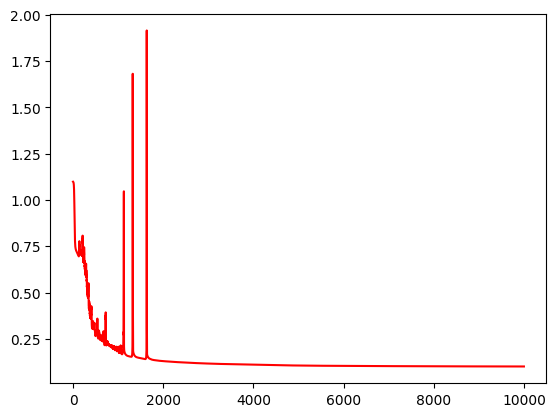

In [14]:
# 繪製 loss 隨訓練次數變化的圖
plt.plot(losses, color='r')